[View in Colaboratory](https://colab.research.google.com/github/keshan/neural_style_transfer/blob/master/Neural_Style_Transfer.ipynb)

Download VGG-19, Content image and Style image to the workspace.

In [3]:
!wget http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
!wget https://www.travellingpearllanka.com/wp-content/uploads/2015/04/featured-discover-srilanka-18d-17n-tour-400x300.jpg
!wget http://www.goldenedgetravels.com/img/goldenedgetravels/img18.jpg

--2018-04-28 08:28:38--  http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534904783 (510M) [text/plain]
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 510.12M  16.5MB/s    in 31s     

2018-04-28 08:29:09 (16.6 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [534904783/534904783]

--2018-04-28 08:29:10--  https://www.travellingpearllanka.com/wp-content/uploads/2015/04/featured-discover-srilanka-18d-17n-tour-400x300.jpg
Resolving www.travellingpearllanka.com (www.travellingpearllanka.com)... 162.213.254.138
Connecting to www.travellingpearllanka.com (www.travellingpearllanka.com)|162.213.254.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87168 (85K) [image/jpeg]
Saving to: ‘featured-discover-srilanka-18d-17n-tour

In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

Defining the VGG-19 model, Loading the downloaded pre-trained weights This model is based on "Very Deep Convolutional Networks for Large-Scale Image Recognition" by Karen Simonyan and Andrew Zisserman https://arxiv.org/pdf/1409.1556.pdf

In [0]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'
    STYLE_IMAGE = 'featured-discover-srilanka-18d-17n-tour-400x300.jpg'
    CONTENT_IMAGE = 'img18.jpg'

def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

Let's have a look at the model.

In [6]:
model = load_vgg_model(CONFIG.VGG_MODEL)
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

Fun part starts from here. The implementations are based on "A Neural Algorithm of Artistic Style" by Leon A. Gatys et al. https://arxiv.org/pdf/1508.06576.pdf

In [0]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C,[-1])
    a_G_unrolled = tf.reshape(a_G,[-1])
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled-a_G_unrolled))/(4*n_H*n_W*n_C)    
    return J_content

In [0]:
def gram_matrix(A):
    GA = tf.matmul(A,tf.transpose(A))   
    return GA

In [0]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_H*n_W, n_C)
    a_S = tf.reshape(a_S, [n_H*n_W, n_C])
    a_G = tf.reshape(a_G, [n_H*n_W, n_C])

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(tf.transpose(a_S)) # the input of gram_matrix is A: matrix of shape (n_C, n_H*n_W)
    GG = gram_matrix(tf.transpose(a_G))

    J_style_layer = tf.reduce_sum(tf.square(GS-GG)) / (4 * n_C**2 * (n_W * n_H)**2)    
    return J_style_layer

In [0]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [0]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        # output tensor of the currently selected layer
        out = model[layer_name]

        # a_S the hidden layer activation from the layer we have selected
        a_S = sess.run(out)

        # a_G is the hidden layer activation from same layer.
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer
    return J_style

In [0]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha*J_content + beta*J_style
    return J

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = load_vgg_model(CONFIG.VGG_MODEL)

In [0]:
def reshape_and_normalize_image(image):
    image = np.reshape(image, ((1,) + image.shape))
    image = image - CONFIG.MEANS
    return image

def save_image(path, image):
    image = image + CONFIG.MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

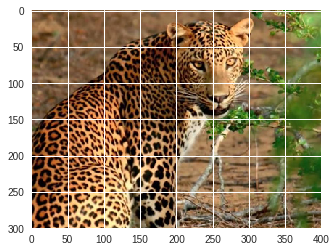

In [16]:
content_image = scipy.misc.imread(CONFIG.CONTENT_IMAGE)
imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

--2018-04-28 08:45:04--  http://lh3.googleusercontent.com/-AO-zg5FNkNw/VquzW0L4mxI/AAAAAAAAOv0/OTAnc-nRj5w/s640/blogger-image--389148106.jpg
Resolving lh3.googleusercontent.com (lh3.googleusercontent.com)... 74.125.28.132, 2607:f8b0:400e:c04::84
Connecting to lh3.googleusercontent.com (lh3.googleusercontent.com)|74.125.28.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67731 (66K) [image/jpeg]
Saving to: ‘blogger-image--389148106.jpg’

blogger-image--3891 100%[===================>]  66.14K  --.-KB/s    in 0s      

2018-04-28 08:45:04 (257 MB/s) - ‘blogger-image--389148106.jpg’ saved [67731/67731]



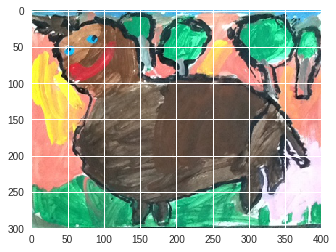

In [26]:
#!wget http://lh3.googleusercontent.com/-AO-zg5FNkNw/VquzW0L4mxI/AAAAAAAAOv0/OTAnc-nRj5w/s640/blogger-image--389148106.jpg
style_image = scipy.misc.imread(CONFIG.STYLE_IMAGE)
#style_image = scipy.misc.imread("blogger-image--389148106.jpg")
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

In [0]:
def generate_noise_image(content_image, noise_ratio=CONFIG.NOISE_RATIO):
    noise_image = np.random.uniform(-20, 20,
                                    (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype(
        'float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

In [0]:
generated_image = generate_noise_image(content_image)

In [0]:
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = compute_content_cost(a_C, a_G)

In [0]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)
J = total_cost(J_content,J_style,10,40)
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [0]:
def model_nn(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image(str(i) + ".jpg", generated_image)
    
    save_image('generated_image.jpg', generated_image)
    
    return generated_image

In [32]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 8639792000.0
content cost = 8352.745
style cost = 215992700.0
Iteration 20 :
total cost = 1472217600.0
content cost = 18673.215
style cost = 36800772.0
Iteration 40 :
total cost = 673634300.0
content cost = 21426.145
style cost = 16835500.0
Iteration 60 :
total cost = 431098430.0
content cost = 22810.082
style cost = 10771758.0
Iteration 80 :
total cost = 317502900.0
content cost = 23560.91
style cost = 7931682.5
Iteration 100 :
total cost = 251050740.0
content cost = 24138.076
style cost = 6270234.0
Iteration 120 :
total cost = 206437550.0
content cost = 24588.969
style cost = 5154791.5
Iteration 140 :
total cost = 174148590.0
content cost = 24964.648
style cost = 4347473.5
Iteration 160 :
total cost = 149553520.0
content cost = 25288.127
style cost = 3732516.0
Iteration 180 :
total cost = 130238210.0
content cost = 25581.9
style cost = 3249559.8


array([[[[-126.431526 ,  -90.300964 ,   65.54516  ],
         [-160.07909  ,  -68.17236  ,  -19.252312 ],
         [-176.81125  ,  -80.26964  ,   36.687855 ],
         ...,
         [ -67.59926  ,  -44.85269  ,  -94.16291  ],
         [  -3.0619571,    2.3468487, -166.9704   ],
         [  20.818888 ,   45.138046 ,  -40.765453 ]],

        [[-194.95345  ,  -92.07776  ,   18.00338  ],
         [-211.81046  ,  -71.8992   ,   11.437618 ],
         [-157.87875  ,  -62.399178 ,  171.21297  ],
         ...,
         [  23.316177 ,   97.15549  ,  -16.955976 ],
         [  61.012203 ,  119.95292  ,  -28.379198 ],
         [  52.720993 ,  114.23326  ,   51.455368 ]],

        [[ -80.12316  ,  -37.489265 ,  140.48003  ],
         [-101.15826  ,  -55.437782 ,  145.31119  ],
         [-126.45723  ,  -58.62177  ,  115.2256   ],
         ...,
         [-152.79344  ,   66.02012  ,  -31.177513 ],
         [-134.58017  ,    9.699043 ,  -53.395695 ],
         [ -39.008545 ,   48.074062 ,  -82.201866 ]],

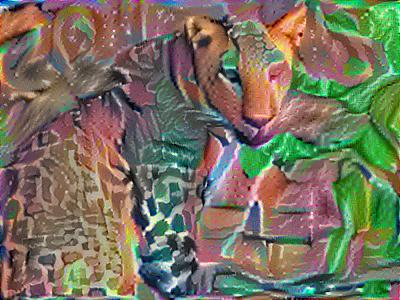

In [33]:
from IPython.display import Image
Image(filename="generated_image.jpg")


0.jpg	 60.jpg
100.jpg  80.jpg
120.jpg  blogger-image--389148106.jpg
140.jpg  datalab
160.jpg  featured-discover-srilanka-18d-17n-tour-400x300.jpg
180.jpg  generated_image.jpg
20.jpg	 imagenet-vgg-verydeep-19.mat
40.jpg	 img18.jpg


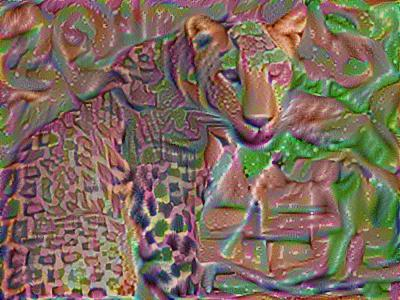

In [38]:
!ls
Image(filename="40.jpg")